In [41]:
file_path='/path/tomato-disease.zip'

In [42]:
# from google.colab import drive
# import zipfile
# import os

# # Step 1: Mount Google Drive
# drive.mount('/content/drive')

# # Step 2: Define the path to the ZIP file in Google Drive
# zip_path = '/content/drive/My Drive'+file_path  # Update this path

# # Step 3: Extract the ZIP file to /data directory
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('./data')

In [43]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch

In [44]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subfolders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        # Collect all image paths and their corresponding labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [45]:
data_dir = "./data/tomato-disease"
batch_size = 32
seed=42
train_split = 0.7
val_split = 0.15

## Splitting data into training and testing sets

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = ImageFolderDataset(data_dir, transform=transform)


# Calculate lengths for splits
total_size = len(full_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

# Split dataset
torch.manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 # use 4 for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

classes = full_dataset.classes
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 318
Validation batches: 69
Test batches: 69


# Bulding Model

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [49]:
class TomatoDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(TomatoDiseaseClassifier, self).__init__()

        # Load pre-trained ResNet50 model with updated weights argument
        self.base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Freeze all layers except the final classifier
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.base_model.fc.weight.requires_grad = True
        self.base_model.fc.bias.requires_grad = True

        # Replace the final fully connected layer with an additional layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        return self.base_model(x)

In [50]:
model = TomatoDiseaseClassifier(num_classes=len(full_dataset.classes))
model = model.to(device)

# Use Adam optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(
    model.base_model.fc.parameters(), lr=0.1, weight_decay=0.01
)

# Loss function
criterion = nn.CrossEntropyLoss()

In [51]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss with L2 regularization
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.*correct/total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                val_pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        epoch_val_loss = running_loss / len(val_loader)
        epoch_val_acc = 100.*correct/total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

Starting training...


Epoch 1/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.68it/s, loss=43.2, acc=68.2]



Epoch 1/10:
Train Loss: 34.6906, Train Acc: 51.39%
Val Loss: 17.4806, Val Acc: 68.24%


Epoch 2/10 [Val]: 100%|██████████| 69/69 [00:11<00:00,  5.79it/s, loss=7.95e-8, acc=68.9]



Epoch 2/10:
Train Loss: 26.9781, Train Acc: 62.17%
Val Loss: 16.4205, Val Acc: 68.93%


Epoch 3/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.58it/s, loss=0, acc=70.9]



Epoch 3/10:
Train Loss: 25.0298, Train Acc: 64.97%
Val Loss: 15.7560, Val Acc: 70.90%


Epoch 4/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.59it/s, loss=0, acc=57.4]



Epoch 4/10:
Train Loss: 20.5020, Train Acc: 66.37%
Val Loss: 44.6051, Val Acc: 57.41%


Epoch 5/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.62it/s, loss=7.95e-8, acc=78.2]



Epoch 5/10:
Train Loss: 21.0740, Train Acc: 67.51%
Val Loss: 6.9411, Val Acc: 78.25%


Epoch 6/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.58it/s, loss=8.85, acc=55.2]



Epoch 6/10:
Train Loss: 24.9597, Train Acc: 65.93%
Val Loss: 36.0953, Val Acc: 55.16%


Epoch 7/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s, loss=114, acc=22.5]



Epoch 7/10:
Train Loss: 23.8919, Train Acc: 68.00%
Val Loss: 106.4653, Val Acc: 22.53%


Epoch 8/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.71it/s, loss=38.7, acc=73.4]



Epoch 8/10:
Train Loss: 40.3560, Train Acc: 65.69%
Val Loss: 22.9044, Val Acc: 73.43%


Epoch 9/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.55it/s, loss=5.55, acc=60.3]



Epoch 9/10:
Train Loss: 24.9304, Train Acc: 70.28%
Val Loss: 40.9465, Val Acc: 60.26%


Epoch 10/10 [Val]: 100%|██████████| 69/69 [00:12<00:00,  5.58it/s, loss=0, acc=81]



Epoch 10/10:
Train Loss: 20.3650, Train Acc: 70.51%
Val Loss: 8.9166, Val Acc: 80.95%


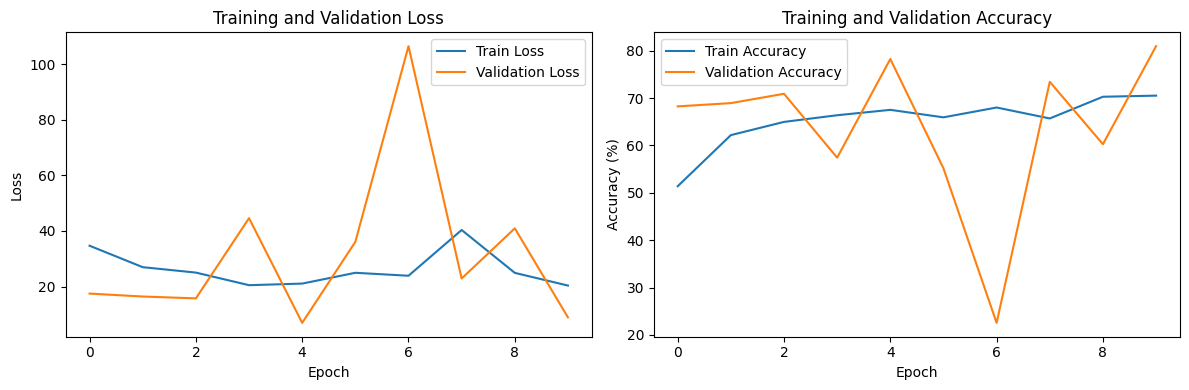

In [52]:
# Train the model
print("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device
)

# Plot training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.81
Confusion Matrix:


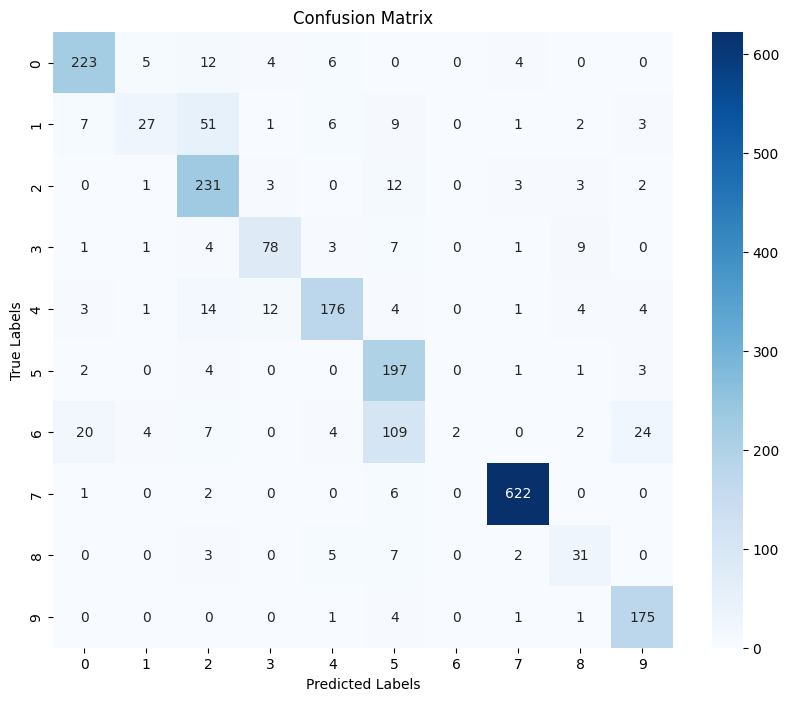

In [54]:
# Inference script to test test_loader
def run_inference(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)
    softmax = nn.Softmax(dim=1)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probabilities = softmax(outputs)
            _, preds = torch.max(probabilities, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate and display the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


run_inference(model,test_loader,device)